This script will
- Get data from stations
- Get processed altimeter data
- Plot data location
- Plot time series altimeter and station
- Calculate and Plot accuracies
- Separate low level from high levels

In [1]:
from ground_data import GroundObservations
from ts_preprocesing import *#get_date_time_cols
import scipy.interpolate as sc
import geopandas as gpd
from timezonefinder import TimezoneFinder
# from ts_preprocesing import convert_units
import importlib
import pandas as pd
import os
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import pytz
from pytz import timezone
import timeit
from datetime import datetime
utc=pytz.utc
utc.zone
%load_ext autoreload
%autoreload 2

In [12]:
#Test Getting data from stations
#So far what works
# Getting locss stations
# Getting ARHN stations 
# Getting USGS stations from file. Still working on R script connection
go=GroundObservations()

lc_lakes=['KHB2','HMT2','PHN2','SAW2','RAW2','BTN2','QUL2', 'WEW2', 'CFN2','YSL2','SLL2','TAB2','MAB2']
df_locss=go.read_ground_data('LOCSS', station_id=lc_lakes)
df_locss=get_date_time_cols(df_locss, 'date', has_hour=True)
stations=df_locss['gauge_id'].unique()
height_fd='height'
df_final=convert_units(df_locss,height_fd, origin='FEET', to='METER', check_col=True, unit_fd='unit',
                  gauge_fd='gauge_id')


##'2102' Is a meteorlogical station 

ar_lakes=['1805', '1819', '1824', '2830', '1830','2832', '2028','2231','2234','2300','2316']
skip_rows=1

df_arhn=go.read_ground_data('ARHN', skip_rows=skip_rows, station_id=ar_lakes)
df_arhn=get_date_time_cols(df_arhn, 'date', has_hour=True)

us_lakes=['2464800','6903880','6604000']
df_usgs=go.read_ground_data('USGS',station_id=us_lakes)
df_usgs=get_date_time_cols(df_usgs, 'date')

rvbr_lakes=['19069','19060','19126']
df_rvbr=go.read_ground_data('RVBR', station_id=rvbr_lakes)
df_rvbr=get_date_time_cols(df_rvbr,'date')

#falta Brazil
# df['file_name'].str.split('_', expand=True)


19069 ['br_19069_MACHADINHO.xlsx']
19060 ['br_19060_SEGREDO.xlsx']
19126 ['br_19126_XINGO.xlsx']


In [13]:
#Relevant columns
# df_ground_ts=pd.DataFrame()
common_cols=['gauge_id','source','decimal_y','height','date','year', 'month', 'day', 'hour']
df_usgs[common_cols]
df_ground_ts=pd.concat((df_usgs[common_cols].copy(),df_arhn[common_cols].copy(), df_final[common_cols].copy(), df_rvbr[common_cols].copy()), axis=0)
# pd.datetime(+pd.to_datetime(df_final['time'], format='%H:%M:%S'), format='%Y-%m-%d %H:%M:%S')
df_ground_ts.columns

Index(['gauge_id', 'source', 'decimal_y', 'height', 'date', 'year', 'month',
       'day', 'hour'],
      dtype='object')

In [6]:
df_ground_ts.loc[df_ground_ts['gauge_id']=='19069']

,gauge_id,source,decimal_y,height,date,year,month,day,hour,Nome,Afluência (m³/s),Defluência (m³/s),Vazão Vertida (m³/s),Vazão Turbinada (m³/s),Vazão Natural (m³/s),Volume Útil (%),Vazão Incremental (m³/s)
0,19069,RVBR,2000.001366,NaN,2000-01-01,2000,1,1,12,MACHADINHO,"151,59","151,59",NaN,NaN,"154,02",NaN,NaN
1,19069,RVBR,2000.004098,NaN,2000-01-02,2000,1,2,12,MACHADINHO,"154,87","154,87",NaN,NaN,"157,28",NaN,NaN
2,19069,RVBR,2000.006831,NaN,2000-01-03,2000,1,3,12,MACHADINHO,"220,59","220,59",NaN,NaN,"222,97",NaN,NaN
3,19069,RVBR,2000.009563,NaN,2000-01-04,2000,1,4,12,MACHADINHO,"431,79","431,79",NaN,NaN,"434,14",NaN,NaN
4,19069,RVBR,2000.012295,NaN,2000-01-05,2000,1,5,12,MACHADINHO,"308,63","308,63",NaN,NaN,"310,95",NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8126,19069,RVBR,2022.247945,"474,32",2022-04-01,2022,4,1,12,MACHADINHO,"438,59","303,00","0,00","303,00","468,80","59,32",NaN
8127,19069,RVBR,2022.250685,"474,52",2022-04-02,2022,4,2,12,MACHADINHO,"469,50","300,00","0,00","300,00","435,93","60,70",NaN
8128,19069,RVBR,2022.253425,"474,45",2022-04-03,2022,4,3,12,MACHADINHO,"240,67","300,00","0,00","300,00","419,55","60,22",NaN
8129,19069,RVBR,2022.256164,"474,44",2022-04-04,2022,4,4,12,MACHADINHO,"398,53","407,00","0,00","407,00","579,08","60,15",NaN


In [8]:
def open_match_station_altis(g_path,altis_name, st_fd, df_gts, st_id,altis_date_fd, altis_height_fd, nodataalti=-9999, ncolgeoid=None,wse_ref='g'):
    #Read altis
    (altiyear, altimonth, altiday, altihour, altiminute, altiwelev)=load_altis(g_path+altis_name+'.csv', 
                                                                               altis_date_fd, altis_height_fd, 
                                                                               nodataalti=-9999, ncolgeoid=ncolgeoid, wse_ref=wse_ref)
    # Compute decimal year from year/month/day from altimetry time series
    altidy = np.array(list(map(yearmonthdayhourminutesec2decimalyear,
                           altiyear, altimonth, altiday, altihour,
                           altiminute, np.zeros(altiday.shape))))
    
    dic_altis={'decimal_y':altidy,'height':altiwelev,'year':altiyear, 'month':altimonth, 'day':altiday, 'hour':altihour}
    
    df_altis=pd.DataFrame(dic_altis)
    df_altis['name_altis']=altis_name
    df_gts_st=df_gts.loc[df_gts[st_fd]==st_id].copy()
    
    return (df_altis, df_gts_st)

def get_common_period(df_ts1, df_ts2, date_ts1_fd, date_ts2_fd, delta_days=False, ndays=0):
    '''Get the common period of time between two time series, df_ts1 and df_ts2
        It can return the common period + or - a number of days based on df_ts1
        Assume both dataframe datetime is utc
        If delta_days=False, ndays is assume =0, returns a common dataframe with the interception between the two dataframes
        If delta_days=True, ndays has to be different from 0
            Rules:
                if df_ts1 starts earlier than df_ts2, common period starts at initial time of df_ts2
                if df_ts1 starts later than df_ts2, common period starts ndays earlier than initial time of df_ts1
                if df_ts1 ends earlier than df_ts2, common period ends ndays later than final time of df_ts1
                if df_ts1 ends later than df_ts2, common period end at the final time of df_ts2
    '''
    
    if delta_days==True and ndays<=0:
        #TODO:Convert this to raise exceptions
        print('Error ndays cannot be 0 or lower if delta_days=True')
        return None
    if delta_days==False:
        ndays=0
    
    utc=pytz.utc
    
    #Min and max dates in df_ts1 and df_ts2
    earlier_date_ts1=utc.localize(min(df_ts1[date_ts1_fd]))
    final_date_ts1=utc.localize(max(df_ts1[date_ts1_fd]))
    
    earlier_date_ts2=utc.localize(min(df_ts2[date_ts2_fd]))
    final_date_ts2=utc.localize(max(df_ts2[date_ts2_fd]))
    
    if earlier_date_ts1 >= earlier_date_ts2:
        initial_date=utc.localize(earlier_date_ts1 - timedelta(days=ndays))
    else:
        initial_date=earlier_date_ts2
        
        
    if final_date_ts1 >= final_date_ts2:
        end_date=final_date_ts2
    else:
        end_date=utc.localize(final_date_ts1 + timedelta(days=ndays))
    
    #filter dataframes
    df_ts1=df_ts1.loc[(df_ts1[date_ts1_fd]>=initial_date)&(df_ts1[date_ts1_fd]<=end_date)].copy()
    df_ts2=df_ts2.loc[(df_ts2[date_ts2_fd]>=initial_date)&(df_ts2[date_ts2_fd]<=end_date)].copy()
    
    return (df_ts1, df_ts2)
        


In [26]:
# #read all altiss 


# import geoplot as gplt
# #WRITE AS FUNCTIONS TO MOVE LATER
# #Read shapefile with all the coordinates and the id of the files
#path= '/home/angelica/Dropbox/Research/LOCSS/Denis_Sylvain/15_L_Altis_20220318/lonlat_vs_altis_ed.shp' When it is a shape file
path= '../data/alti_timeseries/lonlat_vs_altis_ed.csv'
lon_fd='lon'
lat_fd='lat'
# altis_shp
#altis_shp=gpd.read_file(path)
altis_csv=pd.read_csv(path)
#Add the time_zone to each coordinate 
tf=TimezoneFinder()
# altis_shp['tz']=[tf.timezone_at(lng=row[0], lat=row[1]) for row in altis_shp[[lon_fd, lat_fd]]]


# altis_shp['tz']=altis_shp.apply(lambda x:tf.timezone_at(lng=x[lon_fd],lat=x[lat_fd]), axis=1)
altis_csv['tz']=altis_csv.apply(lambda x:tf.timezone_at(lng=x[lon_fd],lat=x[lat_fd]), axis=1)

#filter only altis time series with ground observations
# altis_w_gts_shp=altis_shp.loc[altis_shp['station_id'].notna()]
altis_w_gts_csv=altis_csv.loc[altis_csv['station_id'].notna()]


#Read each file and convert it to dataframe
g_path='../data/alti_timeseries/'
df_gts=df_ground_ts

st_fd='gauge_id'
st_date_fd='date'
altis_date_fd = 'date'  # Same value for Sentinel-3A/B
altis_height_fd = 'ice1_ku_SurfHeight_alti_median'  # Same value for Sentinel-3A/B
nodataalti=-9999

wse_ref='e'
ncolgeoid='geoid_01_median' #PENDING RAISE AND HANDLE THE EXCEPTION WHEN geoid column not found

i=1
df_final_altis=pd.DataFrame()
df_final_ground=pd.DataFrame()


for index,row in altis_w_gts_csv.iterrows():
    # print(row['station_id'])
    altis_name=row['altivs_nam']
    st_id=row['station_id']
    
    # Call every altis relative to the ellipsoide
    
    # is_Sentinel=altis_name.find('Sentinel-3')
    # if is_Sentinel!=-1:
        #Call the function with geoid field and wse_type='e'
        
    df_altis, df_ground_st=open_match_station_altis(g_path,altis_name, st_fd, df_gts, st_id,altis_date_fd, altis_height_fd,
                                                        nodataalti,ncolgeoid=ncolgeoid,wse_ref=wse_ref)
    # else:
        #Call the function with geoid field and wse_type='g'
        # df_altis, df_ground_st=open_match_station_altis(g_path,altis_name, st_fd, df_gts, st_id,altis_date_fd, altis_height_fd, nodataalti)
    print('Station '+row['tz'], st_id+' ground_st: '+str(not df_ground_st.empty)+' df_altis: '+str(df_altis.shape))
    if not df_ground_st.empty:
        # print('df_altis\n', df_altis.head(3))
        # print('df_ground_st '+st_id+'\n', df_ground_st.head(3))
        df_altis['ground_st_1']=st_id
        #Convert time in df_gts_st to UTC
        source=df_ground_st['source'].iloc[0]
        #if source !='RVBR':
        #     continue
            
       # df_ground_st['date_utc']=df_ground_st[st_date_fd].dt.tz_localize(row['tz']).dt.tz_convert('utc')
        df_ground_st['date_utc']=[timezone(row['tz']).localize(date).astimezone(utc.zone) for date in df_ground_st[st_date_fd]]
        # print(df_ground_st.head(), st_id)
        
       
        #print('\nBefore: '+st_id+'\n', df_ground_st[[st_date_fd,'date_utc','decimal_y']].head())
        if source=='USGS':
            df_ground_st=get_date_time_cols(df_ground_st, st_date_fd, has_hour=False)
        else:
            df_ground_st=get_date_time_cols(df_ground_st, st_date_fd, has_hour=True)
        #print('\nAfter: '+st_id+'\n', df_ground_st[[st_date_fd,'date_utc','decimal_y']].head())
        df_ground_st=df_ground_st.sort_values(by=['decimal_y'])
        df_altis=df_altis.sort_values(by=['decimal_y'])
        
        df_ground_st['altis_d_1']=altis_name

        #Concat to final dataframes 
        df_final_altis=pd.concat((df_final_altis, df_altis), axis=0)
        df_final_ground=pd.concat((df_final_ground, df_ground_st), axis=0)

        #Get the max and mins
        altis_min=df_altis['decimal_y'].min()
        ground_min=df_ground_st['decimal_y'].min()
        altis_max=df_altis['decimal_y'].max()
        ground_max=df_ground_st['decimal_y'].max()
        # print('\nAltis_min Ground_min: ',[altis_min, ground_min])
        # print('\nAltis_max Ground_max: ',[altis_max, ground_max])
        #print('\nAltis_min Ground_min: ',[altis_min, ground_min])
        if altis_min>ground_min:
            df_ground_plot=df_ground_st.loc[(df_ground_st['decimal_y']>=altis_min)]#&(df_ground_st['decimal_y']<altis_max)]
            df_altis_plot=df_altis
        else:
            df_ground_plot=df_ground_st
            df_altis_plot=df_altis.loc[(df_altis['decimal_y']>=ground_min)]#&(df_ground_st['decimal_y']<altis_max)]


        (inh_2_altidy, corr_alti_insi, ns_alti_insi, rmse_alti_insi,
         ampl_insi) = interp_ts12ts2_stat(df_ground_plot['decimal_y'].to_numpy(), df_ground_plot['height'].to_numpy(), 
                                          df_altis_plot['decimal_y'].to_numpy(), df_altis_plot['height'].to_numpy())

        error_m_text='\nR2: '+str(np.round(corr_alti_insi, decimals=2))+' | '+\
        'NSE: '+str(np.round(ns_alti_insi,decimals=2))+'\n'+\
        'RMSE: '+str(np.round(rmse_alti_insi,decimals=2))+' | '+\
        'Max Min diff: '+str(np.round(ampl_insi,decimals=2))+'\n'



        plt.figure(i, figsize=(20, 6))
        splot=plt.plot(df_altis_plot['decimal_y'], 
                       df_altis_plot['height']-np.nanmean(df_altis_plot['height']), '-bo', markersize=1.5, label=altis_name)
        gplot=plt.plot(df_ground_plot['decimal_y'], 
                       df_ground_plot['height']-df_ground_plot['height'].mean(), '-go', markersize=1.5, label='Ground Obs '+source+' '+st_id)
        iplot=plt.plot(df_altis_plot['decimal_y'].to_numpy(), 
                       inh_2_altidy-np.nanmean(inh_2_altidy), '--ks', markersize=3, label='Interp ground to altis')
        #plt.plot(altidy, altiwelev, '-ro', markersize=2.5)
        plt.gca().get_xaxis().get_major_formatter().set_useOffset(False)
        ax=plt.gca()
        plt.text(0.01, 0.8, 'Metrics'+error_m_text, fontsize = 15, transform=ax.transAxes)
        plt.xlabel('Time (decimal year)', size=15, weight='bold')
        plt.ylabel('Water elev. dev from mean (m)', size=15, weight='bold')
        plt.grid('on')
        plt.legend(loc='upper right')
        plt.title('Deviation from the mean time series comparison', size=15,
                  weight='bold')
        time_fig=datetime.now().strftime("%Y%m%d_%H_%M")
        path_name='../data/plots_'+time_fig+'/'
        
        if not os.path.isdir(path_name):
            os.mkdir(path_name) 
        
        plt.savefig(path_name+source+'_'+st_id+'_vs_'+altis_name+'.png',
                    bbox_inches='tight')
        plt.show()
        plt.close()
        # Plot time series
        #plt.figure(i+1, figsize=(20, 6))
        # jplot=plt.plot(altidy, altiwelev, '-bo', markersize=2.5, label='Jason-3_011_S2599')
        # splot=plt.plot(df_altis_plot['decimal_y'], 
        #                df_altis_plot['height'], '-go', markersize=1.5, label=altis_name)
        # gplot=plt.plot(df_ground_plot['decimal_y'], 
        #                df_ground_plot['height'], '-ro', markersize=1.5, label='Ground Obs '+st_id)
        # iplot=plt.plot(df_altis_plot['decimal_y'].to_numpy(), 
        #                 inh_2_altidy, '--ks', markersize=3, label='Interp ground to altis')
        # #plt.plot(altidy, altiwelev, '-ro', markersize=2.5)
        # plt.gca().get_xaxis().get_major_formatter().set_useOffset(False)
        # plt.xlabel('Time (decimal year)', size=15, weight='bold')
        # plt.ylabel('Water elevation (m)', size=15, weight='bold')
        # plt.grid('on')
        # plt.legend()
        # plt.title('Water elevation (m)', size=15,
        #           weight='bold')
        # plt.savefig('../data/plots/'+source+'ground_interp_'+st_id+'_vs_'+altis_name+'.png',
        #              bbox_inches='tight')
        i=i+1
        
        
    
    #['gauge_id','source'
    
# def open_match__plot_station_altis(g_path,altis_name, st_id, df_gts, altis_date_fd, altis_height_fd, nodataalti=-9999):


Station America/Argentina/Salta 1824 not ground_st: True df_altis: (73, 7)
Station America/Argentina/Salta 2028 not ground_st: True df_altis: (77, 7)
Error: no column geoid_01_median in ../data/alti_timeseries/AlTiS_TimeSeries_Jason-3_0215_S4017.csv
Station America/Argentina/Salta 2028 not ground_st: True df_altis: (104, 7)
Error: no column geoid_01_median in ../data/alti_timeseries/AlTiS_TimeSeries_Jason-3_GDR-F_0215_S4017.csv
Station America/Argentina/Salta 2028 not ground_st: True df_altis: (157, 7)
Station America/Argentina/Catamarca 2234 not ground_st: True df_altis: (76, 7)
Station America/Argentina/Catamarca 2234 not ground_st: True df_altis: (75, 7)
Station America/Argentina/Catamarca 2316 not ground_st: True df_altis: (41, 7)
Station America/New_York BTN2 not ground_st: True df_altis: (41, 7)
Station America/New_York CFN2 not ground_st: True df_altis: (61, 7)
Station America/Edmonton HMT2 not ground_st: True df_altis: (73, 7)
Station Asia/Dhaka KHB2 not ground_st: True df_alti

<ipython-input-133-58e5424b45ad>:104: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(i, figsize=(20, 6))


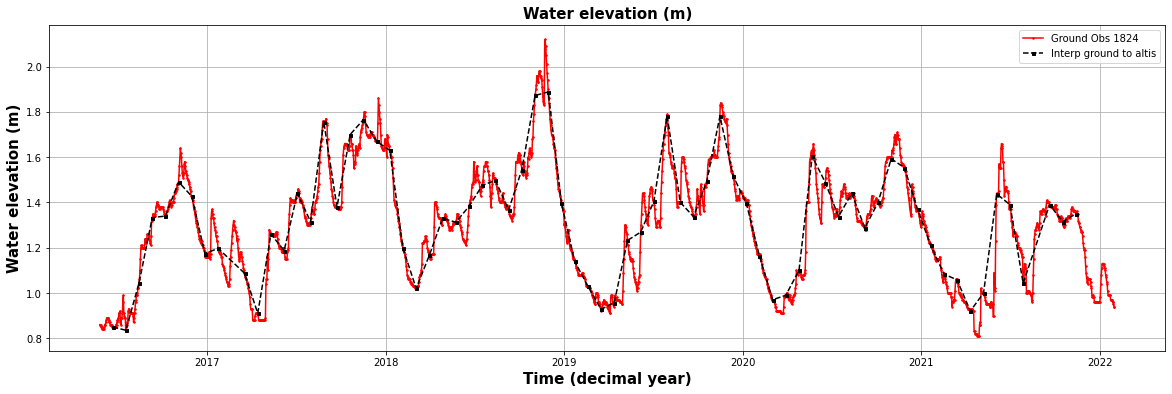

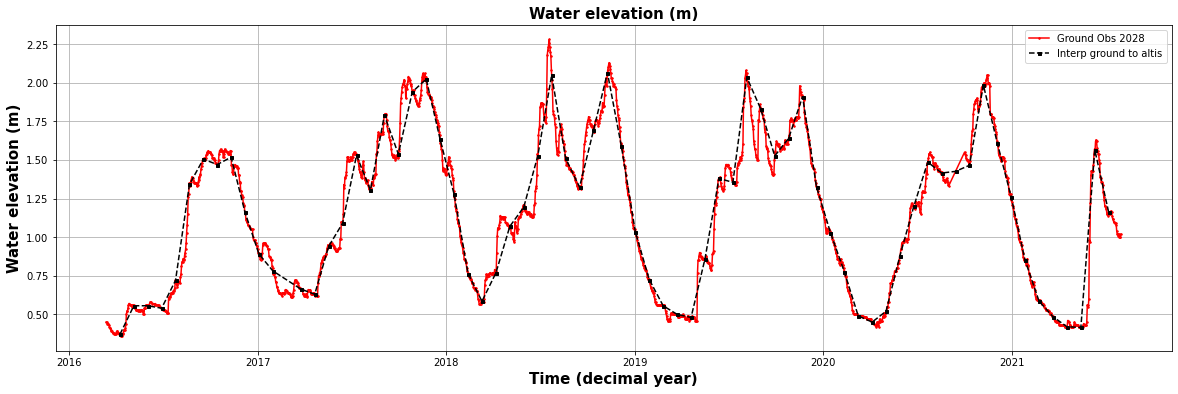

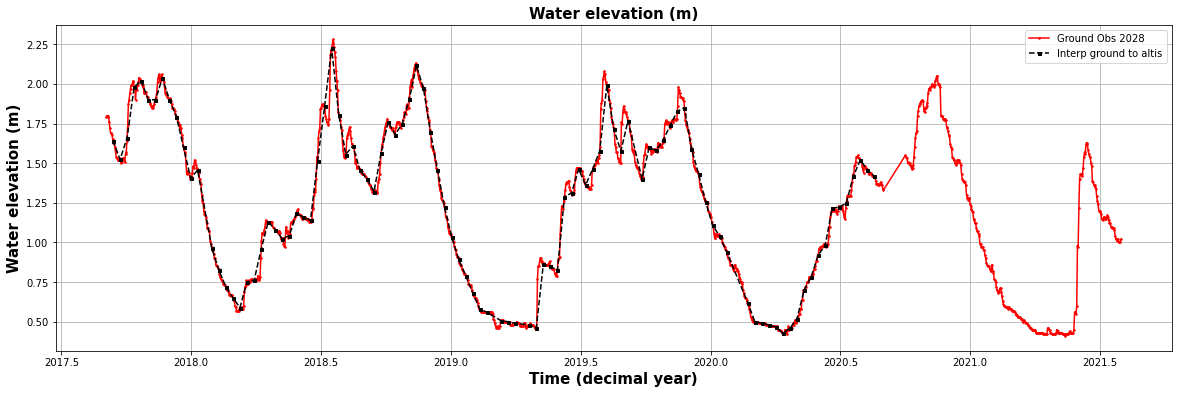

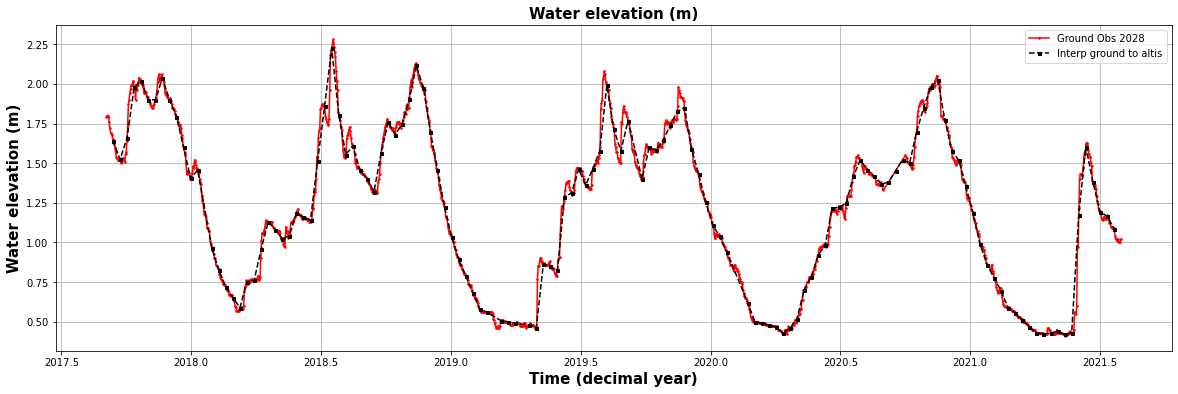

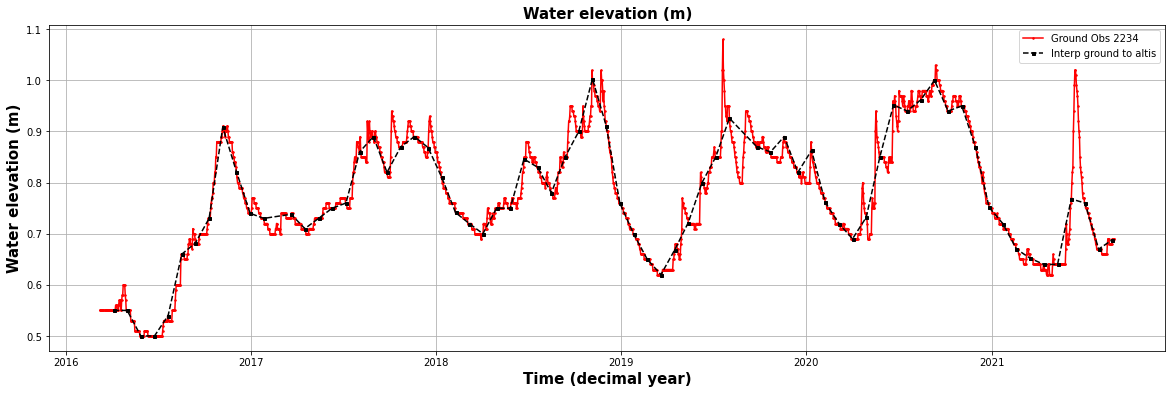

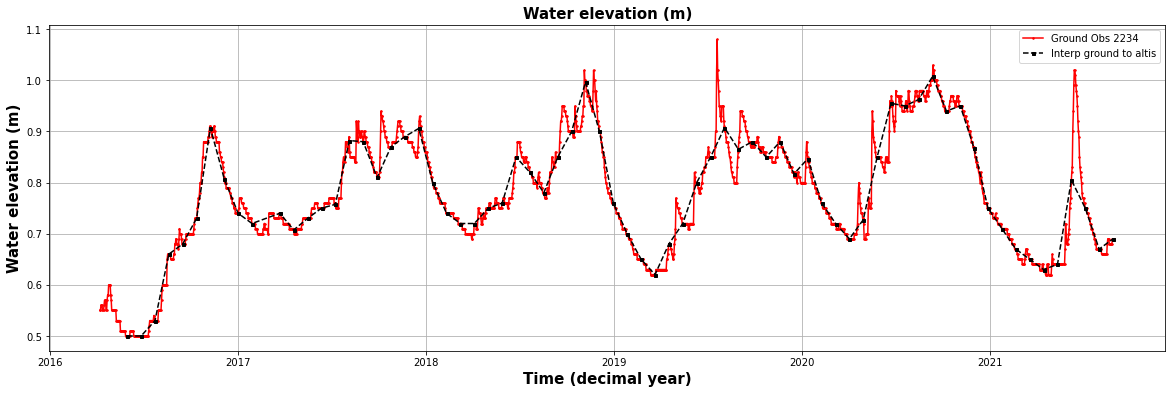

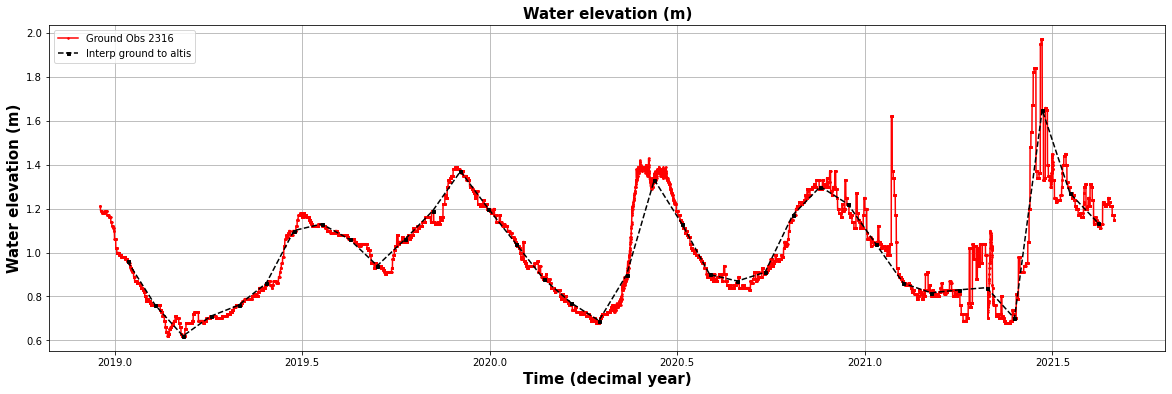

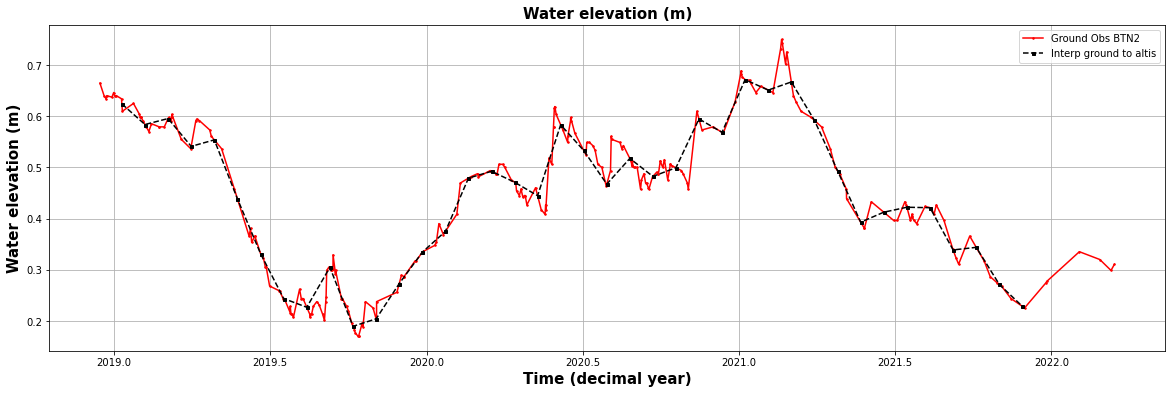

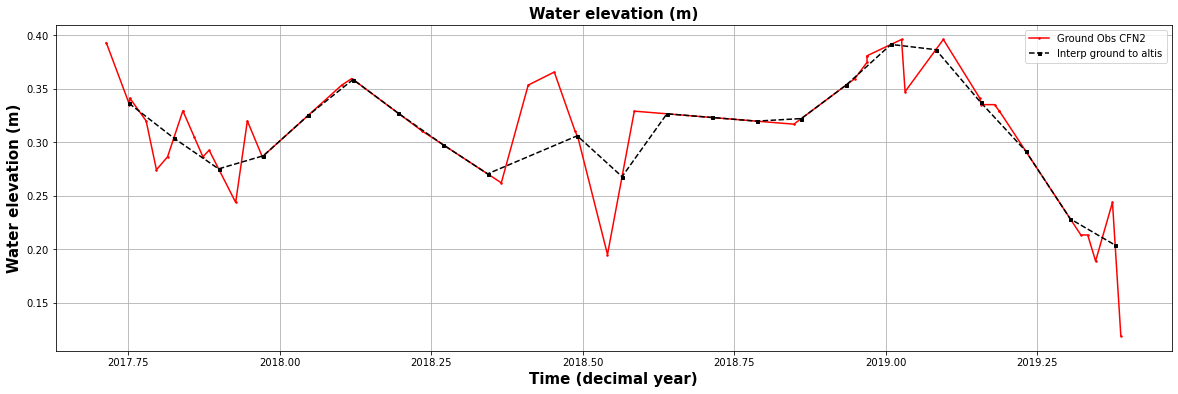

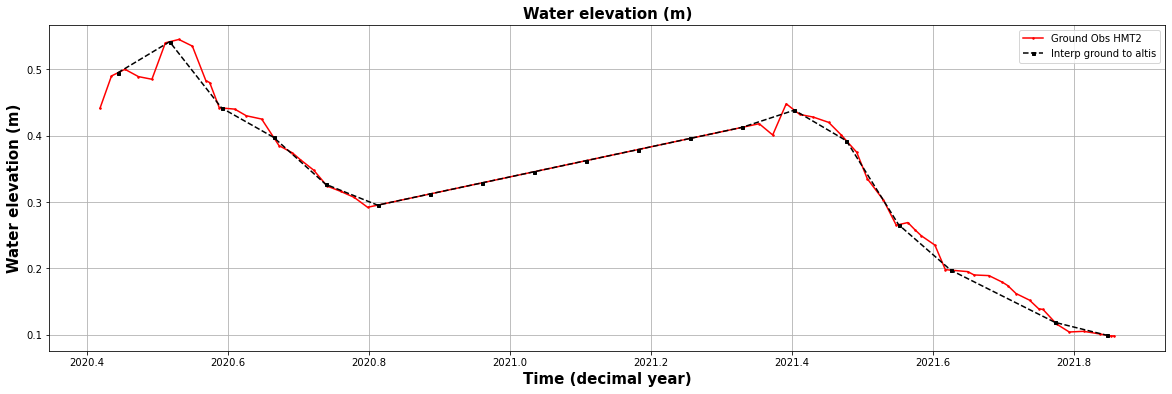

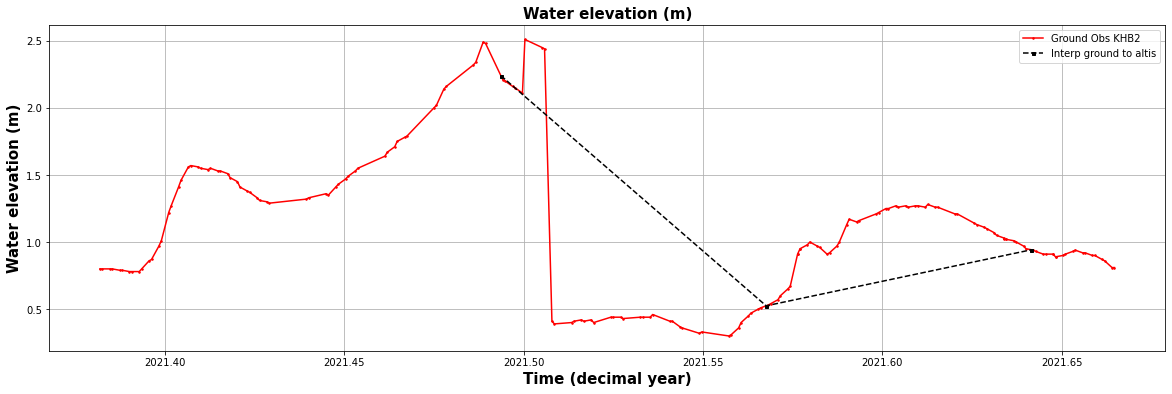

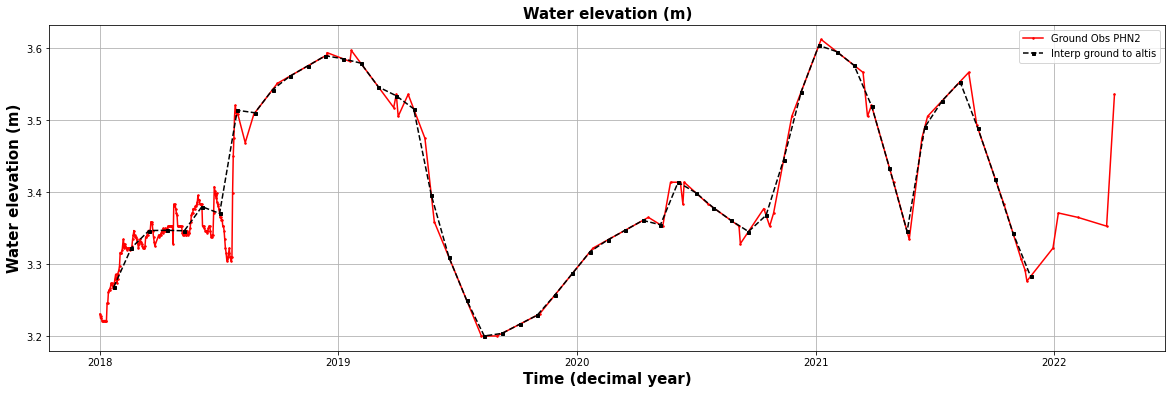

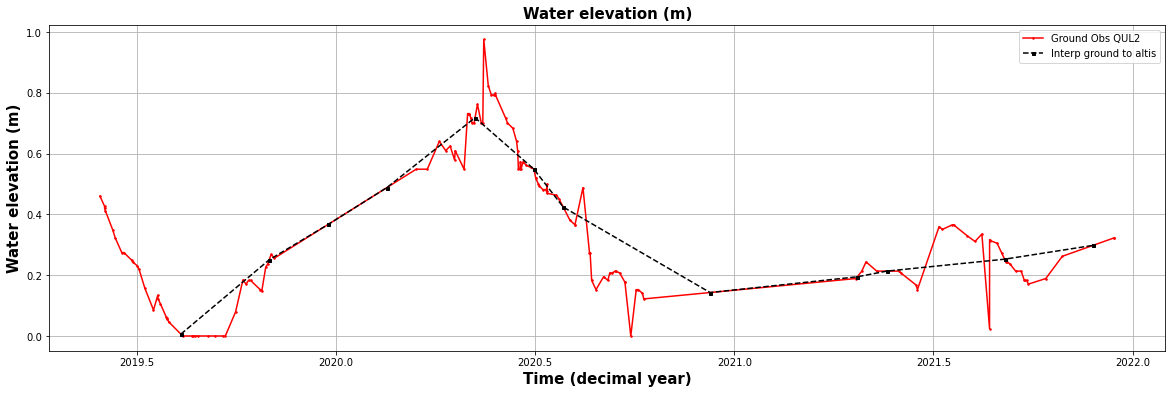

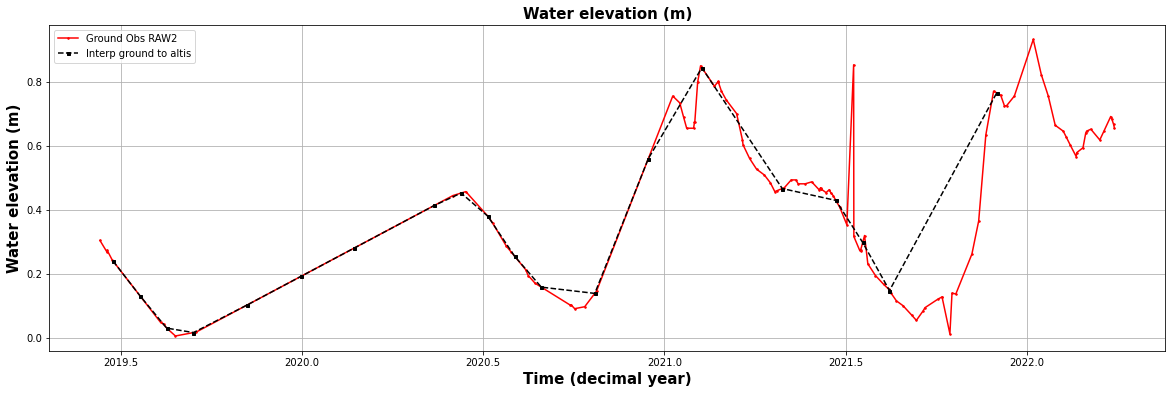

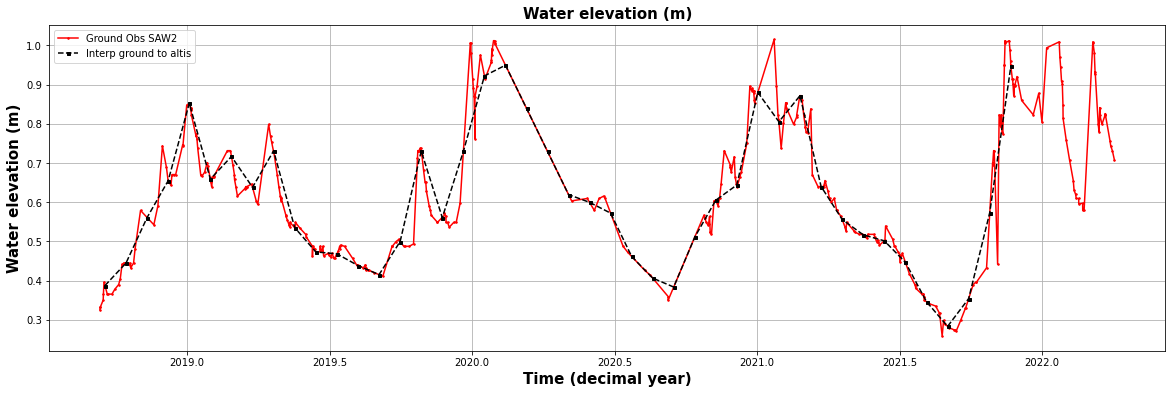

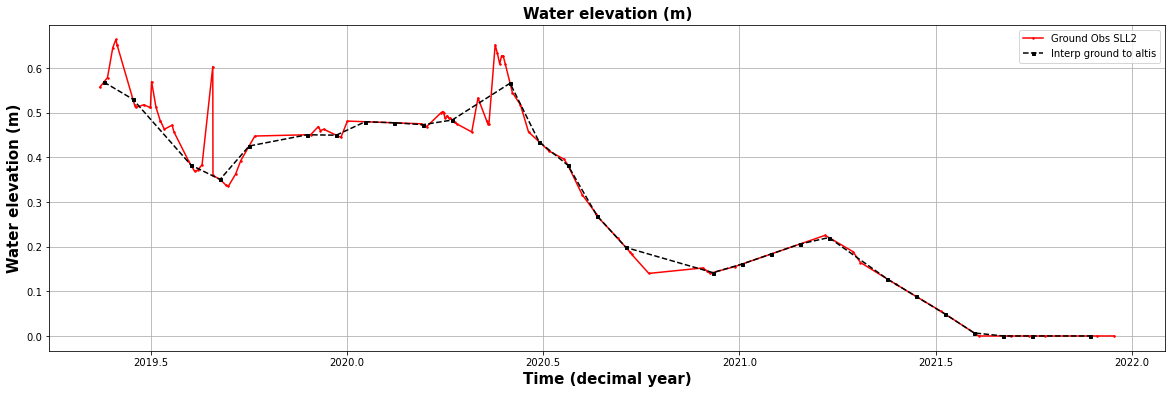

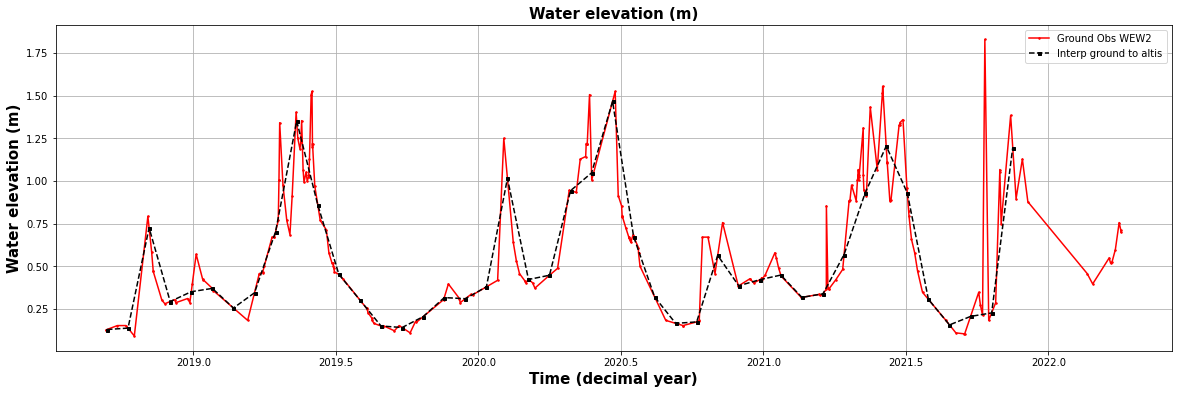

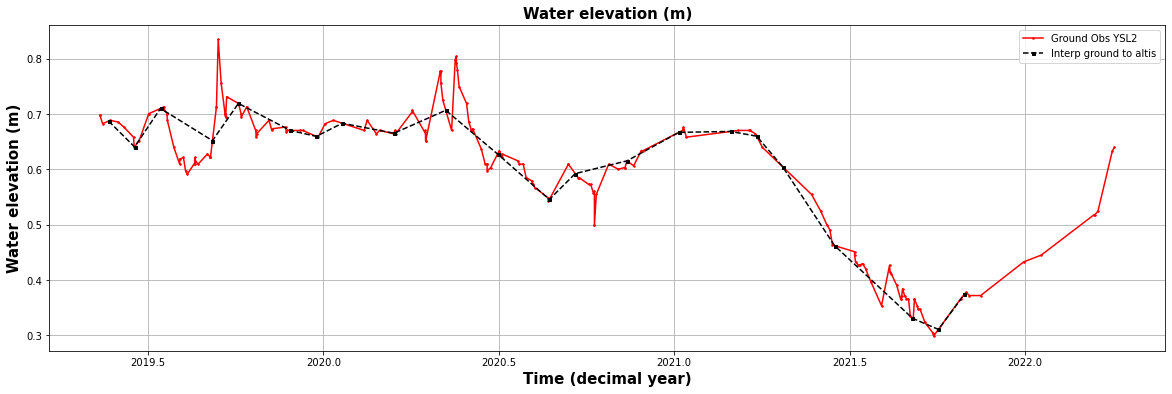

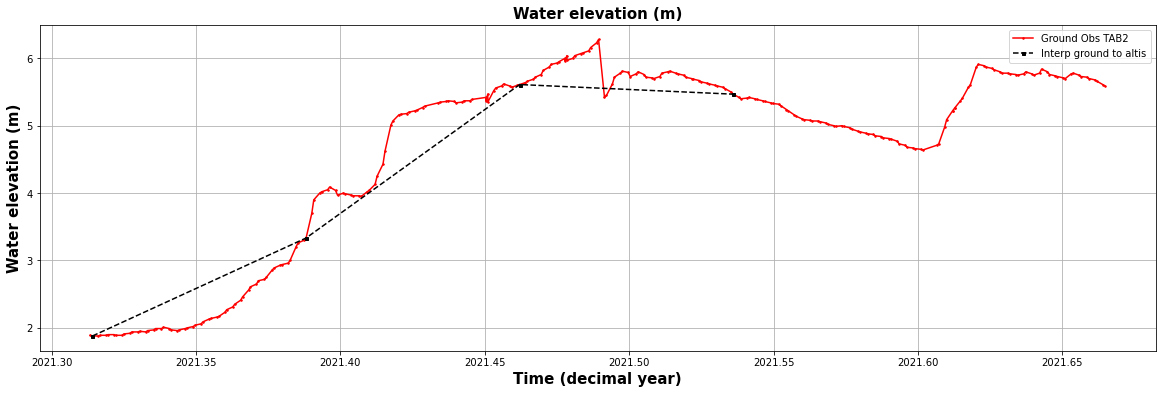

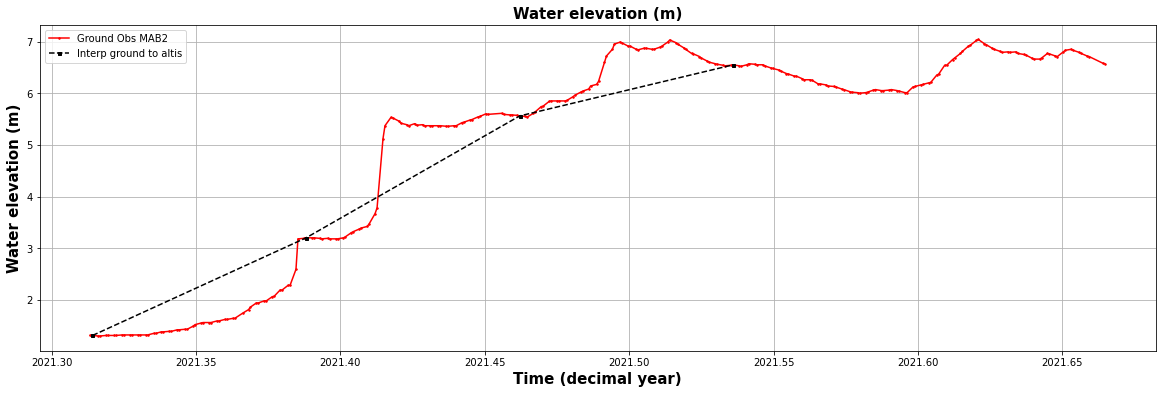

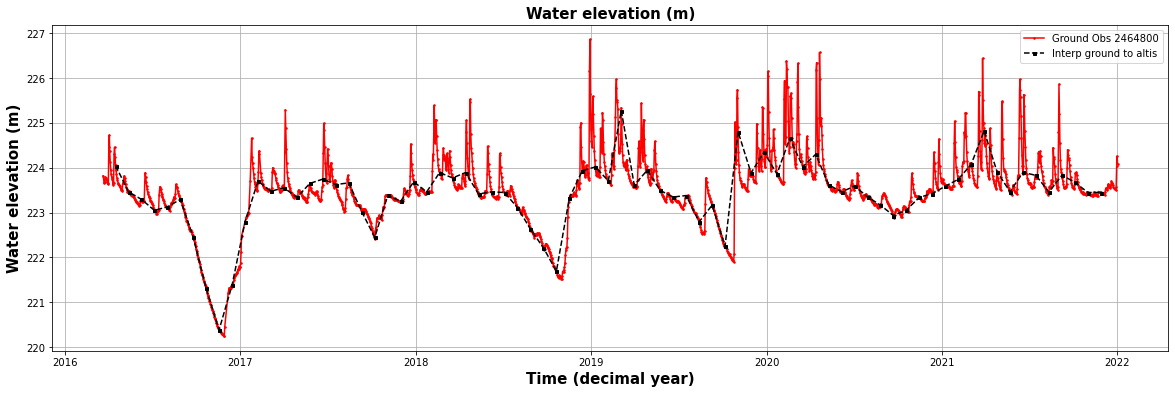

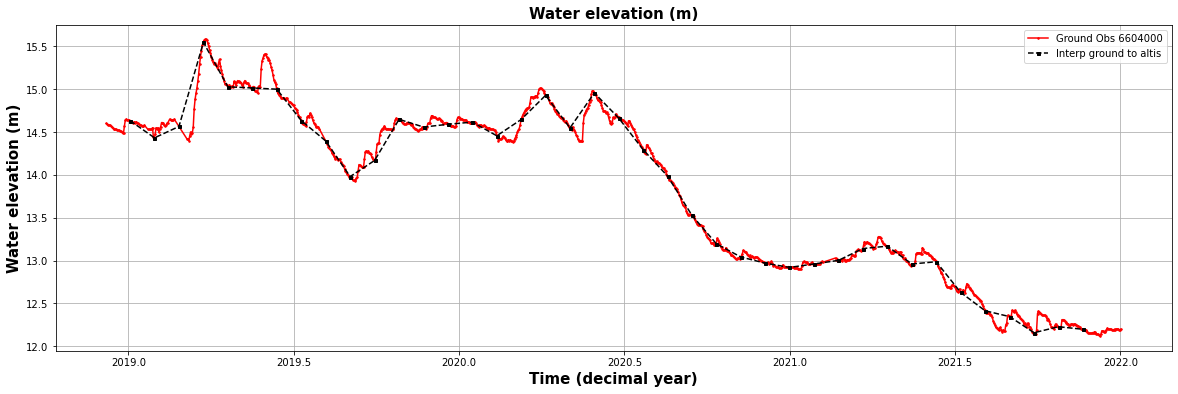

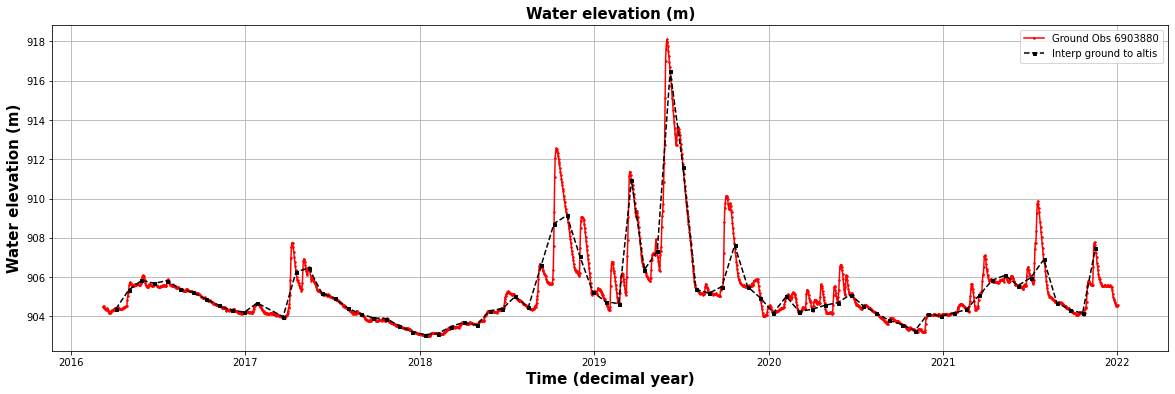

In [133]:
# #read all altiss 


# import geoplot as gplt
# #WRITE AS FUNCTIONS TO MOVE LATER
# #Read shapefile with all the coordinates and the id of the files
#path= '/home/angelica/Dropbox/Research/LOCSS/Denis_Sylvain/15_L_Altis_20220318/lonlat_vs_altis_ed.shp' When it is a shape file
path= '../data/alti_timeseries/lonlat_vs_altis_ed.csv'
lon_fd='lon'
lat_fd='lat'
# altis_shp
#altis_shp=gpd.read_file(path)
altis_csv=pd.read_csv(path)
#Add the time_zone to each coordinate 
tf=TimezoneFinder()
# altis_shp['tz']=[tf.timezone_at(lng=row[0], lat=row[1]) for row in altis_shp[[lon_fd, lat_fd]]]


# altis_shp['tz']=altis_shp.apply(lambda x:tf.timezone_at(lng=x[lon_fd],lat=x[lat_fd]), axis=1)
altis_csv['tz']=altis_csv.apply(lambda x:tf.timezone_at(lng=x[lon_fd],lat=x[lat_fd]), axis=1)

#filter only altis time series with ground observations
# altis_w_gts_shp=altis_shp.loc[altis_shp['station_id'].notna()]
altis_w_gts_csv=altis_csv.loc[altis_csv['station_id'].notna()]
# print(altis_shp.shape)
# print(altis_w_gts_shp.shape)
# print(altis_w_gts_shp.columns)
# print(altis_csv.shape)
# print(altis_w_gts_csv.shape)
# print(altis_w_gts_csv.columns)

#Read each file and convert it to dataframe
g_path='../data/alti_timeseries/'
df_gts=df_ground_ts

st_fd='gauge_id'
st_date_fd='date'
altis_date_fd = 'date'  # Same value for Sentinel-3A/B
altis_height_fd = 'ice1_ku_SurfHeight_alti_median'  # Same value for Sentinel-3A/B
nodataalti=-9999
i=1
df_final_altis=pd.DataFrame()
df_final_ground=pd.DataFrame()

for index,row in altis_w_gts_csv.iterrows():
    # print(row['station_id'])
    altis_name=row['altivs_nam']
    st_id=row['station_id']
    
    df_altis, df_ground_st=open_match_station_altis(g_path,altis_name, st_fd, df_gts, st_id,altis_date_fd, altis_height_fd, nodataalti)
    
    if not df_ground_st.empty:
        # print('df_altis\n', df_altis.head(3))
        # print('df_ground_st '+st_id+'\n', df_ground_st.head(3))
        df_altis['ground_st_1']=st_id
        source=df_ground_st['source'].iloc[0]
        if source=='RVBR':
            continue
        #Convert time in df_gts_st to UTC
        
        df_ground_st['date_utc']=df_ground_st[st_date_fd].dt.tz_localize(row['tz']).dt.tz_convert('utc')
        #print(df_ground_st.head(), st_id)
        
        #print('\nBefore: '+st_id+'\n', df_ground_st[[st_date_fd,'date_utc','decimal_y']].head())
        if source=='USGS':
            df_ground_st=get_date_time_cols(df_ground_st, st_date_fd, has_hour=False)
        else:
            df_ground_st=get_date_time_cols(df_ground_st, st_date_fd, has_hour=True)
        #print('\nAfter: '+st_id+'\n', df_ground_st[[st_date_fd,'date_utc','decimal_y']].head())
        df_ground_st=df_ground_st.sort_values(by=['decimal_y'])
        df_ground_st['altis_d_1']=altis_name

        #Concat to final dataframes 
        df_final_altis=pd.concat((df_final_altis, df_altis), axis=0)
        df_final_ground=pd.concat((df_final_ground, df_ground_st), axis=0)

        #Get the max and mins
        altis_min=df_altis['decimal_y'].min()
        ground_min=df_ground_st['decimal_y'].min()
        altis_max=df_altis['decimal_y'].max()
        ground_max=df_ground_st['decimal_y'].max()
        # print('\nAltis_min Ground_min: ',[altis_min, ground_min])
        # print('\nAltis_max Ground_max: ',[altis_max, ground_max])
        #print('\nAltis_min Ground_min: ',[altis_min, ground_min])
        if altis_min>ground_min:
            df_ground_plot=df_ground_st.loc[(df_ground_st['decimal_y']>=altis_min)]#&(df_ground_st['decimal_y']<altis_max)]
            df_altis_plot=df_altis
        else:
            df_ground_plot=df_ground_st
            df_altis_plot=df_altis.loc[(df_altis['decimal_y']>=ground_min)]#&(df_ground_st['decimal_y']<altis_max)]


        (inh_2_altidy, corr_alti_insi, ns_alti_insi, rmse_alti_insi,
         ampl_insi) = interp_ts12ts2_stat(df_ground_plot['decimal_y'].to_numpy(), df_ground_plot['height'].to_numpy(), 
                                          df_altis_plot['decimal_y'].to_numpy(), df_altis_plot['height'].to_numpy())

        error_m_text='\nR2: '+str(np.round(corr_alti_insi, decimals=2))+' | '+\
        'NSE: '+str(np.round(ns_alti_insi,decimals=2))+'\n'+\
        'RMSE: '+str(np.round(rmse_alti_insi,decimals=2))+' | '+\
        'Max Min diff: '+str(np.round(ampl_insi,decimals=2))+'\n'



        plt.figure(i, figsize=(20, 6))
        gplot=plt.plot(df_ground_plot['decimal_y'], 
                       df_ground_plot['height'], '-go', markersize=1.5, label='Ground Obs '+st_id)
        iplot=plt.plot(df_altis_plot['decimal_y'].to_numpy(), 
                        inh_2_altidy, '--ks', markersize=3, label='Interp ground to altis')
        #plt.plot(altidy, altiwelev, '-ro', markersize=2.5)
        plt.gca().get_xaxis().get_major_formatter().set_useOffset(False)
        plt.xlabel('Time (decimal year)', size=15, weight='bold')
        plt.ylabel('Water elevation (m)', size=15, weight='bold')
        plt.grid('on')
        plt.legend()
        plt.title('Water elevation (m)', size=15,
                  weight='bold')
        plt.savefig('../data/plots/'+source+'_ground_interp_'+st_id+'_vs_'+altis_name+'.png',
                     bbox_inches='tight')
        i=i+1
        
        
    
    #['gauge_id','source'
    
# def open_match__plot_station_altis(g_path,altis_name, st_id, df_gts, altis_date_fd, altis_height_fd, nodataalti=-9999):


In [134]:
df_altis_plot

,decimal_y,height,year,month,day,hour,name_altis,ground_st_1
0,2016.183479,275.212348,2016,3,8,3,AlTiS_TimeSeries_Sentinel-3A_0635_N4086,6903880
1,2016.257250,275.298792,2016,4,4,3,AlTiS_TimeSeries_Sentinel-3A_0635_N4086,6903880
2,2016.331020,275.150594,2016,5,1,3,AlTiS_TimeSeries_Sentinel-3A_0635_N4086,6903880
3,2016.404791,275.351242,2016,5,28,3,AlTiS_TimeSeries_Sentinel-3A_0635_N4086,6903880
4,2016.478561,275.598305,2016,6,24,3,AlTiS_TimeSeries_Sentinel-3A_0635_N4086,6903880
...,...,...,...,...,...,...,...,...
72,2021.578505,275.578580,2021,7,31,3,AlTiS_TimeSeries_Sentinel-3A_0635_N4086,6903880
73,2021.652477,274.932534,2021,8,27,3,AlTiS_TimeSeries_Sentinel-3A_0635_N4086,6903880
74,2021.726450,274.997760,2021,9,23,3,AlTiS_TimeSeries_Sentinel-3A_0635_N4086,6903880
75,2021.800422,274.833224,2021,10,20,3,AlTiS_TimeSeries_Sentinel-3A_0635_N4086,6903880


In [48]:
df1=go.read_ground_data('LOCSS', station_id=lc_lakes)
# df.shape
# df_locss_filtered=df.loc[df['gauge_id'].isin(lc_lakes)]
# df_locss_filtered.shape
x=df1['gauge_id'].unique()
for a in x:
    print(df1.loc[df1['gauge_id']==a].shape)

(536, 24)
(53, 24)
(170, 24)
(256, 24)
(109, 24)
(393, 24)


In [13]:
df_arhn.head(3)

,date,height,source,gauge_id,year,month,day,hour,decimal_y
0,2010-03-01 12:00:00,2.30,ARHN,2830,2010,3,1,12,2010.163014
1,2010-03-02 12:00:00,2.30,ARHN,2830,2010,3,2,12,2010.165753
2,2010-03-03 13:00:00,2.31,ARHN,2830,2010,3,3,12,2010.168493


In [14]:
df_usgs.head(3)

,Unnamed: 0,agency_cd,gauge_id,date,height,X_00065_00003_cd,source,year,month,day,hour,decimal_y
0,1,USGS,2464800,2002-07-04,223.73,A,USGS,2002,7,4,12,2002.505479
1,2,USGS,2464800,2002-07-05,223.66,A,USGS,2002,7,5,12,2002.508219
2,3,USGS,2464800,2002-07-06,223.61,A,USGS,2002,7,6,12,2002.510959
